In [1]:
import sys 
import os
sys.path.append(os.path.abspath(".."))

import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import re
import itertools 
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]

from speclib import misc, plotting, loaders, graph

%matplotlib inline 

In [2]:
dfa = pd.read_msgpack('../../allan_data/participants_graph_adjacency.msgpack')
mask = dfa.sum() != 0
dfa = dfa.loc[mask, mask]  # drop zero-columns
dfa.head() 

,u0182,u1015,u0778,u0933,u0256,u0659,u0719,u0709,u0748,u0045,...,u0912,u0392,u0060,u0125,u0854,u0404,u0202,u0353,u0382,u0188
u0182,0.0,126.0,134.0,33.0,50.0,0.0,0.0,107.0,4.0,3.0,...,562.0,3.0,20.0,16.0,237.0,0.0,40.0,6.0,26.0,76.0
u1015,126.0,0.0,78.0,286.0,72.0,0.0,14.0,2928.0,11.0,17.0,...,323.0,80.0,24.0,39.0,622.0,2.0,82.0,48.0,34.0,55.0
u0778,134.0,78.0,0.0,43.0,89.0,0.0,9.0,2056.0,3.0,10.0,...,645.0,3.0,21.0,13.0,387.0,2.0,22.0,45.0,67.0,89.0
u0933,33.0,286.0,43.0,0.0,34.0,0.0,0.0,72.0,0.0,110.0,...,13.0,3191.0,6.0,69.0,272.0,4.0,10723.0,0.0,18.0,69.0
u0256,50.0,72.0,89.0,34.0,0.0,0.0,0.0,41.0,0.0,1.0,...,37.0,17.0,0.0,0.0,2722.0,0.0,38.0,0.0,2.0,1.0


In [3]:
qdf = pd.read_json('../../allan_data/RGender_.json')
q = misc.QuestionCompleter(qdf)
f = misc.QuestionFilterer(qdf)
ua = loaders.Useralias() 

qdf.index = qdf.index.map(lambda el: ua[el]) 

Remove persons with more than 10 % null answers

In [4]:
qdf = qdf[(qdf.isna().mean() < 0.10).index]

Unify participants in qdf and dfa

In [5]:
user_union = qdf.index.intersection(dfa.index)
dfa = dfa.filter(items=user_union, axis=0).filter(items=user_union, axis=1)
qdf = qdf.filter(items=user_union, axis=0)

assert dfa.shape[0] == dfa.shape[1]
assert (dfa.values[np.diag_indices_from(dfa.values)] == 0).all()
assert len(qdf.index) == len(dfa.index)
assert len(qdf.index.difference(dfa.index)) == 0

Get alcohol-relarted question answers

In [6]:
alcohol_questions = f['alcohol.+__answer$']
alcohol_questions.head() 

,alcohol_binge10__answer,alcohol_binge5__answer,alcohol_debut__answer,alcohol_drunk__answer,alcohol_everyday__answer,alcohol_very_drunk__answer,alcohol_volume_friday__answer,alcohol_volume_monday__answer,alcohol_volume_saturday__answer,alcohol_volume_sunday__answer,alcohol_volume_thursday__answer,alcohol_volume_tuesday__answer,alcohol_volume_wednesday__answer,alcohol_weekend__answer
u0001,1.0,2.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,30.0,5.0,3.0
u0002,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
u0003,2.0,2.0,1.0,2.0,0.0,2.0,12.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0
u0004,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
u0006,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Remove alcohol NaN-users from qdf 

In [7]:
qdf = qdf[alcohol_questions.notnull().any(axis=1)]

/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Find the persons with whom each person spends the most time

In [8]:
big5_questions = f['bfi_.+_answer$']
big5_questions.head() 

,bfi_art__answer,bfi_calm__answer,bfi_careless__answer,bfi_caring__answer,bfi_cold__answer,bfi_confident__answer,bfi_coorporation__answer,bfi_creative__answer,bfi_currious__answer,bfi_depressed__answer,...,bfi_shy__answer,bfi_social__answer,bfi_stable__answer,bfi_strong_personality__answer,bfi_talk__answer,bfi_taste_art__answer,bfi_tense__answer,bfi_unbalanced__answer,bfi_work__answer,bfi_worry__answer
u0001,1.0,3.0,3.0,3.0,0.0,3.0,4.0,0.0,4.0,1.0,...,1.0,4.0,2.0,4.0,4.0,1.0,0.0,0.0,1.0,2.0
u0002,2.0,3.0,2.0,3.0,3.0,3.0,3.0,4.0,4.0,1.0,...,1.0,2.0,2.0,3.0,3.0,1.0,3.0,2.0,2.0,3.0
u0003,1.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,4.0,1.0,...,3.0,2.0,3.0,3.0,1.0,0.0,2.0,0.0,2.0,2.0
u0004,3.0,3.0,1.0,3.0,2.0,3.0,2.0,3.0,4.0,2.0,...,2.0,2.0,3.0,3.0,2.0,3.0,2.0,1.0,3.0,3.0
u0006,1.0,2.0,0.0,4.0,0.0,3.0,3.0,3.0,3.0,0.0,...,3.0,2.0,4.0,2.0,3.0,0.0,1.0,0.0,3.0,2.0


In [22]:
n_persons = 35
simfnc = graph.cosSim

In [23]:
u = dfa['u0001'] 

Strip out persons not present in alcohol questions dataframe

In [24]:
u = u[u.index.intersection(qdf.index)].sort_values(ascending=False) 

In [25]:
pers_homies = u[:n_persons]
pers_homies.head() 

u0691    1852.0
u0049    1135.0
u0619    1122.0
u0152     968.0
u0023     953.0
Name: u0001, dtype: float64

In [26]:
pers_control_names = qdf.index.difference(pers_homies.index)  # Remove names which is in pers_homies
np.random.shuffle(pers_control_names.values)  # shuffle names
pers_control_names = pers_control_names[:n_persons]  # choose n_persons names
pers_control = dfa.loc['u0001'][pers_control_names]  # select columns in dfa
pers_control.head()  # compute pers_control

u0733     1.0
u0112     4.0
u1036     3.0
u0240    34.0
u0136     0.0
Name: u0001, dtype: float64

In [27]:
assert pers_homies.shape == pers_control.shape

Compute the similarity in the way they answered the questions

In [28]:
dct_alcohol = dict()
for p in pers_homies.index:
    dct_alcohol[('u0001', p)] = simfnc(alcohol_questions.loc['u0001'], alcohol_questions.loc[p])
sim_alcohol_homies = pd.Series(dct_alcohol).sort_values(ascending=False) 

dct_alcohol = dict()
for p in pers_control.index:
    dct_alcohol[('u0001', p)] = simfnc(alcohol_questions.loc['u0001'], alcohol_questions.loc[p])
sim_alcohol_control = pd.Series(dct_alcohol).sort_values(ascending=False) 

In [29]:
display(sim_alcohol_homies.head())
display(sim_alcohol_control.head()) 

u0001  u0580    0.165893
       u0389    0.149209
       u0693    0.147082
       u0705    0.142315
       u0865    0.130435
dtype: float64

u0001  u0001    0.448960
       u0994    0.336957
       u0863    0.161232
       u0306    0.131752
       u0136    0.109614
dtype: float64

Compute the similarity wrt. Big Five personality related questions

In [30]:
dct_big5 = dict()
for p in pers_homies.index:
    dct_big5[('u0001', p)] = simfnc(big5_questions.loc['u0001'], big5_questions.loc[p]) 
sim_big5_homies = pd.Series(dct_big5).sort_values(ascending=False) 

dct_big5 = dict() 
for p in pers_control.index:
    dct_big5[('u0001', p)] = simfnc(big5_questions.loc['u0001'], big5_questions.loc[p]) 
sim_big5_control = pd.Series(dct_big5).sort_values(ascending=False) 

In [31]:
display(sim_big5_homies.head())
display(sim_big5_control.head())

u0001  u0152    0.028864
       u1025    0.028708
       u0465    0.028015
       u0998    0.027597
       u0018    0.027565
dtype: float64

u0001  u0001    0.033833
       u1010    0.030622
       u0535    0.029160
       u1027    0.029111
       u0272    0.028963
dtype: float64

Compute similarity in persons that they hang out around

In [32]:
dct_people = dict()
for p in pers_homies.index:
    dct_people[('u0001', p)] = simfnc(dfa['u0001'], dfa[p]) 
sim_people_homies = pd.Series(dct_people).sort_values(ascending=False) 
dct_people = dict()
for p in pers_control.index:
    dct_people[('u0001', p)] = simfnc(dfa['u0001'], dfa[p]) 
sim_people_control = pd.Series(dct_people).sort_values(ascending=False) 

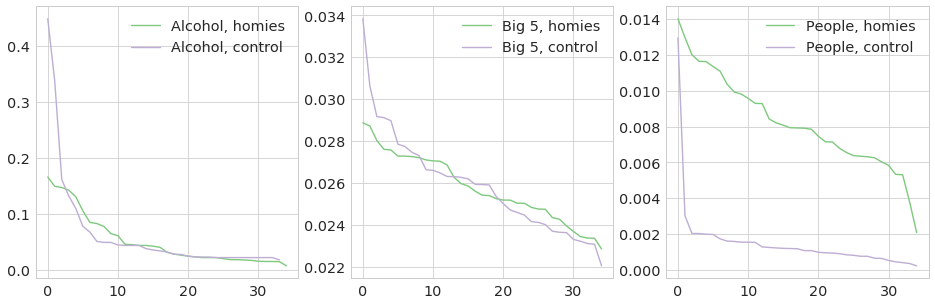

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
ax1.plot(sim_alcohol_homies.values, label="Alcohol, homies")
ax1.plot(sim_alcohol_control.values, label="Alcohol, control")
ax1.legend(loc='best')
ax2.plot(sim_big5_homies.values, label="Big 5, homies")
ax2.plot(sim_big5_control.values, label="Big 5, control")
ax2.legend(loc='best')
ax3.plot(sim_people_homies.values, label="People, homies")
ax3.plot(sim_people_control.values, label="People, control")
ax3.legend(loc='best')


In [34]:
print("sim_alcohol_homies", sim_alcohol_homies.values.shape, sep=':  ')
print("sim_alcohol_control", sim_alcohol_control.values.shape, sep=':  ')
print("sim_big5_homies", sim_big5_homies.values.shape, sep=':  ')
print("sim_big5_control", sim_big5_control.values.shape, sep=':  ')
print("sim_people_homies", sim_people_homies.values.shape, sep=':  ')
print("sim_people_control", sim_people_control.values.shape, sep=':  ') 

sim_alcohol_homies:  (35,)
sim_alcohol_control:  (35,)
sim_big5_homies:  (35,)
sim_big5_control:  (35,)
sim_people_homies:  (35,)
sim_people_control:  (35,)
